In [1]:
from s3ts.api.ucr import load_ucr_classification
from s3ts.api.ts2sts import finite_random_STS
import numpy as np
X, Y, mapping = load_ucr_classification("BasicMotions")
#X, Y, mapping = load_ucr_classification("GunPoint")
print(X.shape, Y.shape, len(np.unique(Y)))

STS, SCS = finite_random_STS(X, Y, length=60)
print(STS.shape, SCS.shape)

Loading 'BasicMotions' from cache...
(80, 6, 100) (80,) 4
(6, 6000) (6000,)


In [2]:
from s3ts.api.ts2sts import compute_medoids
meds, meds_idx = compute_medoids(X, Y, meds_per_class=1, metric="dtw")
patts = meds.squeeze(1)
print(meds.shape, patts.shape)

(4, 1, 6, 100) (4, 6, 100)


In [11]:
from s3ts.api.encodings import compute_DM
DM = compute_DM(STS, patts, rho=0.1, metric="squared") # "euclidean"/"squared"

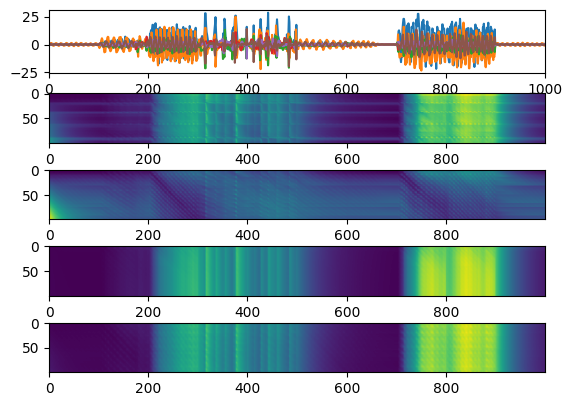

In [12]:
import matplotlib.pyplot as plt
npoints = 1000
fig, ax = plt.subplots(nrows=len(np.unique(Y))+1)
axi: plt.Axes = ax[0]
axi.set_xlim(0, npoints)
[axi.plot(STS[d,:npoints]) for d in range(STS.shape[0])]
for i in range(len(np.unique(Y))):
    axi: plt.Axes = ax[i+1]
    axi.imshow(DM[i,:,:npoints])

In [5]:
from s3ts.api.dm.simple_sts import StaticDM
import numpy as np

STS_len = STS.shape[1]
data_split = {
    "train": np.arange(100, 2*(STS_len//4)),
    "val": np.arange(2*(STS_len//4), 3*(STS_len//4)),
    "test": np.arange(STS_len)}

dm = StaticDM(STS, SCS, DM, 
    wdw_len=10, wdw_str=1, sts_str=False, 
    data_split=data_split, batch_size=32)

5989


In [8]:
from s3ts.api.nets.methods import create_model_from_DM
# name will be the subfolder in training dir
model = create_model_from_DM(dm, name=None, 
        dsrc="img", arch="cnn", task="cls")
print(model)

Input shape:  torch.Size([1, 4, 100, 10])
Latent shape:  torch.Size([1, 40, 6, 10])
WrapperModel(
  (encoder): CNN_IMG(
    (cnn_0): Sequential(
      (0): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (cnn_1): Sequential(
      (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): AvgPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0)
      (3): Dropout(p=0.35, inplace=False)
    )
    (cnn_2): Sequential(
      (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.4, inplace=False)
    )
    (cnn_3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (decoder): LinearDecoder(
    (fcn_inp): Linear(in_features=2400, out_features=64, bias=T

In [9]:
from s3ts.api.nets.methods import train_model
model, data = train_model(dm, model, max_epochs=2)
print(data)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: training/img_cnn_cls_wl10_ws1_ss0_np4_lp100_n4

   | Name       | Type               | Params
---------------------------------------------------
0  | encoder    | CNN_IMG            | 23.9 K
1  | decoder    | LinearDecoder      | 162 K 
2  | flatten    | Flatten            | 0     
3  | softmax    | Softmax            | 0     
4  | train_acc  | MulticlassAccuracy | 0     
5  | train_f1   | MulticlassF1Score  | 0     
6  | val_acc    | MulticlassAccuracy | 0     
7  | val_f1     | MulticlassF1Score  | 0     
8  | val_auroc  | MulticlassAUROC    | 0     
9  | test_acc   | MulticlassAccuracy | 0     
10 | test_f1    | MulticlassF1Score  | 0     
11 | test_auroc | MulticlassAUROC    | 0     
---------------------------------------------------
186 K     Trainable params
0         Non-trainable params


Epoch 1: 100%|██████████| 91/91 [00:03<00:00, 25.45it/s, v_num=0, train_loss_step=1.010, val_loss=1.160, val_acc=0.566, val_auroc=0.0626, train_loss_epoch=1.230, train_acc=0.508]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 91/91 [00:03<00:00, 25.33it/s, v_num=0, train_loss_step=1.010, val_loss=1.160, val_acc=0.566, val_auroc=0.0626, train_loss_epoch=1.230, train_acc=0.508]
Input shape:  torch.Size([1, 4, 100, 10])
Latent shape:  torch.Size([1, 40, 6, 10])
Validation DataLoader 0: 100%|██████████| 47/47 [00:00<00:00, 75.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5661517977714539     │
│         val_auroc         │    0.06263171136379242    │
│          val_f1           │    0.5661517977714539     │
│         val_loss          │    1.1597179174423218     │
└───────────────────────────┴───────────────────────────┘

{'val_acc': 0.5661517977714539, 'val_f1': 0.5661517977714539, 'val_auroc': 0.06263171136379242}


In [10]:
#import torch
#torch.save(model, "pruebas.pt")
#model = torch.load("pruebas.pt")

In [11]:
from s3ts.api.nets.methods import test_model
data = test_model(dm, model)
print(data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 188/188 [00:02<00:00, 64.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5954249501228333     │
│        test_auroc         │    0.07512450963258743    │
│          test_f1          │    0.5954249501228333     │
│         test_loss         │    1.1574490070343018     │
└───────────────────────────┴───────────────────────────┘

{'test_acc': 0.5954249501228333, 'test_f1': 0.5954249501228333, 'test_auroc': 0.07512450963258743}


In [12]:
from s3ts.api.networks import get_test_preds
data, preds = get_test_preds(dm, model)
print(preds.shape)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 188/188 [00:01<00:00, 95.06it/s]
(5989, 4)
